In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_processor_pipeline.cleaner import *
from data_processor_pipeline.custom_dataset import *
from metrics.plot_confusion_matrix import plot_cfs_matrix
from datasets import load_dataset
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

# Data_Preprocess

## Read data and cleaning

In [3]:
data=pd.read_csv('vietnamese_student_feedbacks.csv', encoding='utf-8-sig')
data_processor=data_clean()
data['sentence']=data['sentence'].map(lambda x: data_processor.clean_text(x))

## Multi processiong

In [ ]:
from multiprocessing import Process, Manager

# Function to test multiprocessing
def test(indices):
    print(indices)

indices: list[int] = list(range(0, 20))
n_proc = 8
processes: list[Process] = []

if __name__=="__main__":
    with Manager() as manager:
        indices = manager.list(indices)  # Shared list between processes
        for idx in range(n_proc):
            p = Process(target=test, args=(indices,))  # Pass the shared list to each process
            processes.append(p)
        
        # Start all processes
        for p in processes:
            p.start()
        
        # Wait for all processes to complete
        for p in processes:
            p.join()


In [ ]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

# Hàm thực hiện clean_text với đa luồng
def apply_clean_text_parallel(df, column_name, clean_func):
    # Số lượng luồng bằng số lõi CPU
    num_threads = multiprocessing.cpu_count()
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        df[column_name] = list(executor.map(clean_func, df['sentence']))
    
    return df
df = apply_clean_text_parallel(data, 'cleaned', data_processor.clean_text)

## Train_validation_test

In [4]:
from sklearn.model_selection import train_test_split

data['combined_label']=list(zip(data["sentiment"], data['topic']))
X_train, X_test, y_train, y_test = train_test_split(data['sentence'].reset_index(drop=True).to_list(),
                                                    data['combined_label'].reset_index(drop=True).to_list(),
                                                    test_size=0.1,
                                                    stratify=data['topic'],
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [5]:
len(X_train), len(X_val), len(X_test)

(13101, 1456, 1618)

In [6]:
y_train_sentiment, y_train_topic = zip(*y_train)
y_val_sentiment, y_val_topic = zip(*y_val)
y_test_sentiment, y_test_topic = zip(*y_test)

## Resampled

In [ ]:
df_y_train_sentiment = pd.DataFrame(y_train_sentiment, columns=['y_train_sentiment'])

In [ ]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==1].to_numpy().flatten()
oversample_size = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==0].shape[0] - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([y_train_sentiment, np.array([1] * oversample_size)], axis=0)

In [ ]:
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

## Create dataLoader

## Sentiment

In [7]:
train_dataset_sentiment=Custom_Dataset(X_train, torch.tensor(y_train_sentiment, dtype=torch.long), file_path='vocab.pkl', is_save_vocab=False)
val_dataset_sentiment=Custom_Dataset(X_val, y_val_sentiment, file_path='vocab.pkl', is_save_vocab=False, max_length=train_dataset_sentiment.max_length)
test_dataset_sentiment=Custom_Dataset(X_test, y_test_sentiment, file_path='vocab.pkl', is_save_vocab=False, max_length=train_dataset_sentiment.max_length)

In [8]:
train_loader_sentiment=DataLoader(train_dataset_sentiment, batch_size=16, shuffle=True)
val_loader_sentiment=DataLoader(val_dataset_sentiment, batch_size=16, shuffle=True)
test_loader_sentiment=DataLoader(test_dataset_sentiment, batch_size=16, shuffle=True)

# DL_model for sentiment classification

## RNN

### Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_rnn import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RNN=RNN(vocab_size=5000, embedding_dim=128, num_layers=1, activation=nn.ReLU(), batch_normalization=True, bidirectional=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_RNN=optim.Adam(model_RNN.parameters(), lr=0.01)
epochs=5
trainer=trainer()
log_dir='logs/RNN'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer=SummaryWriter(log_dir='logs/RNN')
print(model_RNN)

RNN(
  (embedding): Embedding(5000, 128)
  (rnn): RNN(128, 64, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
best_Acc_RNN=0
for epoch in range(epochs):
    trainer.train(model_RNN, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_RNN, device)
    val_loss, val_acc = trainer.validation(model_RNN, val_loader_sentiment, criterion, device)
    print(f"VALIDATION | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_RNN.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_RNN.state_dict()
    }
    os.makedirs('model/RNN', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/RNN', 'last.pt'))
    if val_acc>best_Acc_RNN:
        torch.save(checkpoint, os.path.join('model/RNN', 'best.pt'))
        best_Acc_RNN=val_acc

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0532: 100%|███████████████| 819/819 [00:22<00:00, 36.90it/s]


VALIDATION | Epoch: 1/5 | Loss: 0.0541 | Accuracy: 0.4615


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0521: 100%|███████████████| 819/819 [00:20<00:00, 40.02it/s]


VALIDATION | Epoch: 2/5 | Loss: 0.0517 | Accuracy: 0.5350


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0517: 100%|███████████████| 819/819 [00:22<00:00, 36.71it/s]


VALIDATION | Epoch: 3/5 | Loss: 0.0518 | Accuracy: 0.5337


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0515: 100%|███████████████| 819/819 [00:20<00:00, 40.16it/s]


VALIDATION | Epoch: 4/5 | Loss: 0.0519 | Accuracy: 0.5330


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0513: 100%|███████████████| 819/819 [00:20<00:00, 40.63it/s]


VALIDATION | Epoch: 5/5 | Loss: 0.0517 | Accuracy: 0.5357


## Evaluate

In [ ]:
result_RNN_on_test=trainer.evaluate(model_RNN, test_loader_sentiment, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
result_RNN_on_test

{'accuracy': 0.5290482076637825,
 'precision': 0.9336638944854555,
 'recall': 0.5290482076637825,
 'f1-score': 0.6466456879865078,
 'confusion_matrix': array([[ 71,   0, 676],
        [  4,   0,  68],
        [ 14,   0, 785]], dtype=int64)}

## LSTM

In [ ]:
import torch
import torch. nn as nn
import torch.optim as optim

from build_model.build_lstm import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_LSTM=LSTM(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False,output_dim=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=0.001)
trainer = trainer()
log_dir = 'logs/RNN'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print(model_LSTM)

In [ ]:
epochs=5
best_acc=0
for epoch in range(epochs):
    trainer.train(model_LSTM, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_LSTM, device)
    val_loss, val_acc = trainer.validation(model_LSTM, val_loader_sentiment, criterion, device)
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_LSTM.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer_LSTM.state_dict(),
    }
    os.makedirs('model/LSTM', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/LSTM','last.pt'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model/LSTM','best.pt'))
        best_acc=val_acc

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0348: 100%|███████████████| 819/819 [00:29<00:00, 27.46it/s]


TEST | Epoch: 1/5 | Loss: 0.0230 | Accuracy: 0.8826


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0204: 100%|███████████████| 819/819 [00:39<00:00, 20.70it/s]


TEST | Epoch: 2/5 | Loss: 0.0174 | Accuracy: 0.9100


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0162: 100%|███████████████| 819/819 [00:33<00:00, 24.18it/s]


TEST | Epoch: 3/5 | Loss: 0.0169 | Accuracy: 0.9148


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0138: 100%|███████████████| 819/819 [00:32<00:00, 25.48it/s]


TEST | Epoch: 4/5 | Loss: 0.0203 | Accuracy: 0.9059


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0112: 100%|███████████████| 819/819 [00:31<00:00, 25.63it/s]


TEST | Epoch: 5/5 | Loss: 0.0179 | Accuracy: 0.9135


In [ ]:
result_LSTM_on_test=trainer.evaluate(model_LSTM, test_loader_sentiment, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
result_LSTM_on_test

{'accuracy': 0.9023485784919654,
 'precision': 0.9016187811436869,
 'recall': 0.9023485784919654,
 'f1-score': 0.9018738644200714,
 'confusion_matrix': array([[693,  22,  32],
        [ 22,  34,  16],
        [ 47,  19, 733]], dtype=int64)}

## BiLSTM

In [ ]:
import torch
import torch. nn as nn
import torch.optim as optim

from build_model.build_lstm import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BiLSTM=LSTM(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=True,output_dim=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_BiLSTM = optim.Adam(model_BiLSTM.parameters(), lr=0.001)
trainer = trainer()
log_dir = 'logs/RNN'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print(model_BiLSTM)

TypeError: 'trainer' object is not callable

In [ ]:
epochs=5
best_acc=0
for epoch in range(epochs):
    trainer.train(model_BiLSTM, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_BiLSTM, device)
    val_loss, val_acc = trainer.validation(model_BiLSTM, val_loader_sentiment, criterion, device)
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_BiLSTM.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer_BiLSTM.state_dict(),
    }
    os.makedirs('model/BiLSTM', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/BiLSTM','last.pt'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model/BiLSTM','best.pt'))
        best_acc=val_acc

  0%|                                                                                           | 0/819 [00:00<?, ?it/s]

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0329: 100%|███████████████| 819/819 [00:40<00:00, 20.30it/s]


TEST | Epoch: 1/5 | Loss: 0.0202 | Accuracy: 0.8990


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0200: 100%|███████████████| 819/819 [00:46<00:00, 17.61it/s]


TEST | Epoch: 2/5 | Loss: 0.0192 | Accuracy: 0.9073


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0161: 100%|███████████████| 819/819 [00:50<00:00, 16.09it/s]


TEST | Epoch: 3/5 | Loss: 0.0168 | Accuracy: 0.9114


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0123: 100%|███████████████| 819/819 [00:46<00:00, 17.65it/s]


TEST | Epoch: 4/5 | Loss: 0.0177 | Accuracy: 0.9162


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0100: 100%|███████████████| 819/819 [00:41<00:00, 19.66it/s]


TEST | Epoch: 5/5 | Loss: 0.0186 | Accuracy: 0.9128


In [ ]:
result_BiLSTM_on_test=trainer.evaluate(model_BiLSTM, test_loader_sentiment, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
result_BiLSTM_on_test

{'accuracy': 0.9054388133498146,
 'precision': 0.9102988977402795,
 'recall': 0.9054388133498146,
 'f1-score': 0.9076282818423385,
 'confusion_matrix': array([[690,  18,  39],
        [ 24,  29,  19],
        [ 43,  10, 746]], dtype=int64)}

## GRU

### Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_gru import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *
import os

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False,output_dim=3).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_GRU=optim.Adam(model_GRU.parameters(), lr=0.001)
epochs=5
trainer=trainer()
log_dir='logs/GRU'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print(model_GRU)

GRU(
  (embedding): Embedding(5000, 128)
  (gru): GRU(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
import pickle
from build_model.build_gru import *

model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False, output_dim=3)
with open('model_architecture/GRU.pkl','wb') as f:
    pickle.dump(model_GRU, f)

In [ ]:
best_acc=0
for epoch in range(epochs):
    trainer.train(model_GRU, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_GRU, device)
    val_loss, val_acc = trainer.validation(model_GRU, val_loader_sentiment, criterion, device)
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_GRU.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer_GRU.state_dict(),
    }
    os.makedirs('model/GRU', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/GRU','last.pt'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model/GRU','best.pt'))
        best_acc=val_acc

TRAIN | Epoch: 1/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0313: 100%|███████████████| 819/819 [00:40<00:00, 20.31it/s]


TEST | Epoch: 1/5 | Loss: 0.0202 | Accuracy: 0.8929


TRAIN | Epoch: 2/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0191: 100%|███████████████| 819/819 [00:44<00:00, 18.54it/s]


TEST | Epoch: 2/5 | Loss: 0.0176 | Accuracy: 0.9059


TRAIN | Epoch: 3/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0153: 100%|███████████████| 819/819 [00:45<00:00, 18.07it/s]


TEST | Epoch: 3/5 | Loss: 0.0176 | Accuracy: 0.9038


TRAIN | Epoch: 4/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0124: 100%|███████████████| 819/819 [00:45<00:00, 18.19it/s]


TEST | Epoch: 4/5 | Loss: 0.0183 | Accuracy: 0.9107


TRAIN | Epoch: 5/5 | Iter: 819/819 | Error: 0/819 | Loss: 0.0102: 100%|███████████████| 819/819 [00:51<00:00, 15.91it/s]


TEST | Epoch: 5/5 | Loss: 0.0184 | Accuracy: 0.9141


### Evaluate


In [ ]:
from training.trainer import *
from build_model.build_gru import *
trainer=trainer()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False).to(device)
model_state_dict=torch.load('model/GRU/best.pt', map_location=device)
model_GRU.load_state_dict(model_state_dict['model_state_dict'])
result_GRU_on_test=trainer.evaluate(model_GRU, test_loader_sentiment, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
result_GRU_df=pd.DataFrame({
    'accuracy': result_GRU_on_test['accuracy'],
    'precision': result_GRU_on_test['precision'],
    'recall': result_GRU_on_test['recall'],
    'f1-score': result_GRU_on_test['f1-score']
}, index=['GRU'])
result_GRU_df

,accuracy,precision,recall,f1-score
GRU,0.914091,0.932634,0.914091,0.921216


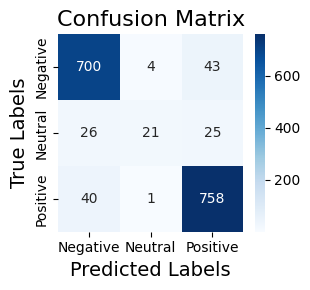

In [ ]:
plot_cfs_matrix(result_GRU_on_test['confusion_matrix'], ["Negative", "Neutral", "Positive"])

### HyperParameters Tuning

In [ ]:
from SearchCV.randomizedSearchCv_GRU import *

In [ ]:
from SearchCV.perform_randomSearch import *

In [ ]:
from scipy.stats import randint, uniform  # Import these for param_dist
param_dist = {
    'embedding_dim': randint(128, 256),
    'num_layers': randint(1, 3),
    'drop_out': uniform(0.2, 0.5),
    'units':  randint(64, 128),
    'activation': [None],
    'batch_normalization': [True, False],
    'bidirectional': [True, False],
    'lr': uniform(0.0001, 0.01),
    'epochs': randint(3, 5)
}

In [ ]:
model_wrapper = PytorchModelWrapper(vocab_size=5000, embedding_dim=128, num_layers=2,
                                    drop_out=0.2,
                                    units=64,
                                    activation=None, 
                                    batch_normalization=True,
                                    bidirectional=False)

In [ ]:
best_params, best_model = perform_random_search_pytorch('GRU', model_wrapper, param_dist,
                                                        train_dataset_sentiment[:]['numericalized_encode'],
                                                        train_dataset_sentiment[:]['labels'],
                                                        n_iter=1,
                                                        cv=2)


GRU model results after HyperParameters Tuning:

Params: {'activation': None, 'batch_normalization': False, 'bidirectional': False, 'drop_out': 0.43213670417397704, 'embedding_dim': 196, 'epochs': 4, 'lr': 0.008929428540843271, 'num_layers': 2, 'units': 110} - Mean test score: 0.89 - Rank: 1

Bests parameters for GRU model: {'activation': None, 'batch_normalization': False, 'bidirectional': False, 'drop_out': 0.43213670417397704, 'embedding_dim': 196, 'epochs': 4, 'lr': 0.008929428540843271, 'num_layers': 2, 'units': 110}



## Bert

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader

In [ ]:
corpus = data['sentence']
# Ghi dữ liệu vào file
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in corpus:
        f.write(line + "\n")

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

tokenizer.pre_tokenizer = Whitespace()

trainer = WordPieceTrainer(vocab_size=5000,
                           special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)

files = ["corpus.txt"]  

tokenizer.train(files, trainer)

tokenizer.save("custom_tokenizer.json")

In [10]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("custom_tokenizer.json")


In [35]:
# Tokenize nhiều câu
sentences = ["Đây là một câu.", "Câu này dài hơn một chút."]
encodings = tokenizer.encode_batch(sentences)

# Thêm padding và truncation
max_length = 10  # Độ dài tối đa

padded_token_ids = [
    encoding.ids + [0] * (max_length - len(encoding.ids)) if len(encoding.ids) < max_length else encoding.ids[:max_length]
    for encoding in encodings
]

# Tạo attention mask
attention_masks = [
    [1 if token != 0 else 0 for token in tokens] for tokens in padded_token_ids
]

print("Attention Masks:", attention_masks)


print("Padded Token IDs:", padded_token_ids)
# Ví dụ: [[101, 234, 876, 112, 0, 0, 0, 0, 0, 0], [101, 876, 234, 789, 543, 0, 0, 0, 0, 0]]


Attention Masks: [[0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0, 0]]
Padded Token IDs: [[0, 280, 361, 668, 0, 0, 0, 0, 0, 0], [0, 453, 1039, 308, 361, 1415, 0, 0, 0, 0]]


In [11]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences=sentences
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_length=max_length
        self.encodings=self.tokenizer.encode_batch(self.sentences)
        print()
        self.padded_token_ids = [
            encoding.ids +[0]* (self.max_length - len(encoding.ids))
            if len(encoding.ids) < self.max_length
            else  encoding.ids[:self.max_length]
            for encoding in self.encodings
        ]
        self.attention_masks = [
            [1 if token !=0 else 0 for token in tokens] for tokens in self.padded_token_ids
        ]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        """
        Trả về một mẫu tại chỉ mục idx.
        Args:
            idx (int): Chỉ mục của mẫu.
        Returns:
            dict: Gồm input_ids, attention_mask, và label.
        """
        return {
            'sentences': self.sentences[idx],
            'input_ids': torch.tensor(self.padded_token_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [29]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length, cls_token="[CLS]", sep_token="[SEP]"):
        """
        Dataset tuỳ chỉnh.
        Args:
            sentences (list): Danh sách các câu.
            labels (list): Danh sách nhãn.
            tokenizer: Tokenizer với hàm encode_batch.
            max_length (int): Độ dài tối đa của mỗi câu.
            cls_token (str): Token bắt đầu câu.
            sep_token (str): Token kết thúc câu.
        """
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.cls_token = cls_token
        self.sep_token = sep_token

        # Thêm token đặc biệt và mã hóa các câu
        self.encodings = self.tokenizer.encode_batch(
            [f"{self.cls_token} {sentence} {self.sep_token}" for sentence in self.sentences]
        )

        # Thêm padding và attention mask
        self.padded_token_ids = [
            encoding.ids + [0] * (self.max_length - len(encoding.ids))
            if len(encoding.ids) < self.max_length
            else encoding.ids[:self.max_length]
            for encoding in self.encodings
        ]
        self.attention_masks = [
            [1 if token != 0 else 0 for token in tokens] for tokens in self.padded_token_ids
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Trả về một mẫu tại chỉ mục idx.
        Args:
            idx (int): Chỉ mục của mẫu.
        Returns:
            dict: Gồm sentences, input_ids, attention_mask, và label.
        """
        return {
            'sentence': self.sentences[idx],
            'input_ids': torch.tensor(self.padded_token_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [24]:
train_dataset = CustomDataset(X_train, y_train_sentiment, tokenizer, max_length=24)
val_dataset = CustomDataset(X_val, y_val_sentiment, tokenizer, max_length=24)
test_dataset = CustomDataset(X_test, y_test_sentiment, tokenizer, max_length=24)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [27]:
optimizer.state_dict().clear()


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class PhoBERTClassifier(nn.Module):
    def __init__(self, phobert_model_name, num_labels):
        super(PhoBERTClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(phobert_model_name)
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        # Sử dụng embedding của token [CLS]
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

model = PhoBERTClassifier("bert-base-uncased", num_labels=3)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [18]:
model

PhoBERTClassifier(
  (phobert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [17]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số trọng số: {total_params}")
print(f"Số trọng số huấn luyện: {trainable_params}")


Tổng số trọng số: 109484547
Số trọng số huấn luyện: 109484547


In [29]:
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        #print(labels.shape)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

EPOCHS = 3

loss_fn = CrossEntropyLoss().to(device)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(X_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


KeyboardInterrupt: 